In [17]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data_paths = {}

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        data_paths[filename] = f"{dirname}/{filename}"



/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100

In [19]:
data = {}

for file, path in data_paths.items():
    data[file.split('.')[0]] = pd.read_csv(path)


list(data.keys())

['items',
 'sample_submission',
 'item_categories',
 'sales_train',
 'shops',
 'test']

In [20]:
def inspect_table(data):
    report = []
    
    for t_name, df in data.items():
        nan_report = df.isna().sum(0) / len(df)
        unique_report = df.nunique()
        types = df.infer_objects().dtypes.astype(str)
        total = [len(df) for _ in range(len(df.columns))]

        report.append( pd.DataFrame(
            data=[
                nan_report.values,
                unique_report.values,
                types,
                total
            ],
            index=['nan_report', 'unique', 'dtype', 'total'],
            columns= pd.MultiIndex.from_tuples([(col, t_name) for col in df.columns], names=["column_name", "table_name"])
        ))
        
    return pd.concat(report, axis=1).transpose().reset_index().sort_values('column_name').set_index(["column_name", "table_name"])



## Overall statistics

In [21]:
report = inspect_table(data)
report

nan_report  unique    dtype    total
column_name        table_name                                            
ID                 test                     0.0  214200    int64   214200
                   sample_submission        0.0  214200    int64   214200
date               sales_train              0.0    1034   object  2935849
date_block_num     sales_train              0.0      34    int64  2935849
item_category_id   items                    0.0      84    int64    22170
                   item_categories          0.0      84    int64       84
item_category_name item_categories          0.0      84   object       84
item_cnt_day       sales_train              0.0     198  float64  2935849
item_cnt_month     sample_submission        0.0       1  float64   214200
item_id            sales_train              0.0   21807    int64  2935849
                   test                     0.0    5100    int64   214200
                   items                    0.0   22170    int64    22170
item_name          items                    0.0   22170   object    22170
item_price         sales_train              0.0   19993  float64  2935849
shop_id            test                     0.0      42    int64   214200
                   shops                    0.0      60    int64       60
                   sales_train              0.0      60    int64  2935849
shop_name          shops                    0.0      60   object       60

In [22]:
from functools import partial
from itertools import combinations

def markov_probability_tresh(data, prob=0.03):
    """
        Parameters:
         - data -> list of numerical values X_i >= 0
         - prob -> probability, that occurence will exceed the threshold
         
        Returns:
         - thresh -> threshold, that satisfy P(x >= thresh; data) <= prob
    """
    assert len(list(filter(lambda el: el < 0.0, data))) == 0, "Series should satisfy non-negative value range"
    
    data_mean = np.mean(data)
    return data_mean / prob 
    

def dqc_inspection__base(data, report):    
    report = report.reset_index()
    dqc_report = {}
    
    # Step: schema key consistency
    col_cnt = report.groupby('column_name').table_name.count().reset_index()
    merging_cols = list(col_cnt[col_cnt.table_name > 1].column_name)
    merging_cols__tables = report[report.column_name.isin(merging_cols)]
    
    consistency_table__data = {}
    
    for col in merging_cols:
        table_names = merging_cols__tables[merging_cols__tables.column_name == col]
        
        id_table_pairs = list(combinations(table_names.table_name.values, 2))
        
        for l_table, r_table in id_table_pairs:
        
            cmp_key = f"[{col}] {l_table} - {r_table}"
            l_unique = set(data[l_table][col].unique())
            r_unique = set(data[r_table][col].unique())

            inter_len = len(l_unique.intersection(r_unique))
            consistency_table__data__row = (len(l_unique) - inter_len, inter_len, len(r_unique) - inter_len)

            consistency_table__data[cmp_key] = consistency_table__data__row
        
    dqc_report["consistency_table"] = pd.DataFrame(data=consistency_table__data.values(), columns=['left_cnt_only', 'intersect_len', 'right_cnt_only'], index=consistency_table__data.keys())
     
    
    numeric_report = {}
    aggregation_mapping = {
        'min': min,
        **{
            f'perc_{thresh}': partial(np.quantile, q=(0.01 * thresh), interpolation='nearest') for thresh in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 96, 97, 98, 99]
        },
        'max': max,
    }
    
    # Step: floating point range check
    report__float_rows = report[report.dtype.isin(["float", "float16", "float32", "float64"])]
    
    for _, row in report__float_rows.iterrows():
        col = row.column_name
        tbl = row.table_name
        
        freport_key = f"[Float range] {tbl} - {col}"
        vals = data[tbl][col].values
        freport__tuple = [f(vals) for f in aggregation_mapping.values()]
        
        numeric_report[freport_key] = freport__tuple


    # Step: id duplication stat
    duplication_report = {}
    duplication_candidates = report[report.apply(lambda row: 'id' in row.column_name, axis=1)]
    
    for _, row in duplication_candidates.iterrows():
        col = row.column_name
        tbl = row.table_name
        
        duplication_key = f"[Occurence stat] {tbl} - {col}"
        vals = data[tbl][col].value_counts().values
        duplication_row = [f(vals) for f in aggregation_mapping.values()]
        
        numeric_report[duplication_key] = duplication_row
        
    dqc_report["numeric_report"] = pd.DataFrame(data=numeric_report.values(), columns=aggregation_mapping.keys(), index=numeric_report.keys())
    
    return dqc_report
    

qdc_base_report = dqc_inspection__base(data, report)

# 1. DQC Report

## 1.1 Base report 

In [23]:
qdc_base_report['consistency_table']

,left_cnt_only,intersect_len,right_cnt_only
[ID] test - sample_submission,0,214200,0
[item_category_id] items - item_categories,0,84,0
[item_id] sales_train - test,17070,4737,363
[item_id] sales_train - items,0,21807,363
[item_id] test - items,0,5100,17070
[shop_id] test - shops,0,42,18
[shop_id] test - sales_train,0,42,18
[shop_id] shops - sales_train,0,60,0


Results:
 - `test` needs us to predict items (we have information about them in `items` table), that are not presented in `sales_train` table
 - `test` is represented by a subsample of shops

In [24]:
qdc_base_report['numeric_report']

,min,perc_1,perc_2,perc_3,perc_4,perc_5,perc_10,perc_20,perc_30,perc_40,perc_50,perc_60,perc_70,perc_80,perc_90,perc_95,perc_96,perc_97,perc_98,perc_99,max
[Float range] sales_train - item_cnt_day,-22.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,5.0,2169.0
[Float range] sample_submission - item_cnt_month,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
[Float range] sales_train - item_price,-1.0,5.0,58.0,79.0,99.0,99.0,149.0,199.0,299.0,349.0,399.0,599.0,799.0,1199.0,1999.0,2690.0,2999.0,3190.0,3590.0,5999.0,307980.0
[Occurence stat] items - item_category_id,1.0,1.0,1.0,1.0,2.0,2.0,4.0,7.0,12.0,20.0,46.0,151.0,228.0,317.0,598.0,790.0,1125.0,1780.0,1780.0,2365.0,5035.0
[Occurence stat] item_categories - item_category_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
[Occurence stat] sales_train - item_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,10.0,18.0,32.0,55.0,90.0,160.0,331.0,556.0,655.0,775.0,993.0,1513.0,31340.0
[Occurence stat] test - item_id,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0
[Occurence stat] items - item_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
[Occurence stat] test - shop_id,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0
[Occurence stat] shops - shop_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Outliers:
 - We can see some range outliers in [`sales_train - item_cnt_day`, `sales_train - item_price`]
 - We can see some occurence outliers in [`sales_train - item_id`]

Train data overview:
 - Amount of items sold per purchase among all shops is in range [1-5] (Need to verify `negative values` and `outliers` from business perspective)
 - Item price has a wide range of values but also is affected with `neg values` and `outliers`
 - A huge mass of items is poorly represented in train (need to be tackled somehow as well) + `outliers`
 - Shops are not always representative 

### `Negative values` check

Here we have 2 columns:
 - sales_train - item_price
 - sales_train - item_cnt_day

In [25]:
raw_train = data['sales_train']

neg_item_price = raw_train[raw_train.item_price <= 0.0]
print(f"Percentage of neg samples: {100 * (len(neg_item_price) / len(raw_train))}")

neg_item_price

Percentage of neg samples: 3.406169731481422e-05


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


Can be easily droped

In [26]:
neg_item_cnt_day = raw_train[raw_train.item_cnt_day <= 0.0]
print(f"Percentage of neg samples: {100 * (len(neg_item_cnt_day) / len(raw_train))}")

neg_item_cnt_day

Percentage of neg samples: 0.2505578454477734


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


#### Was it a return or a mistake?

Core assupmtions for a return:
 - They can occure in every shop
 - They can occure at any time
 - They might have some patterns in terms of items and their price

Amount of shops with at least 1 potential return: 54


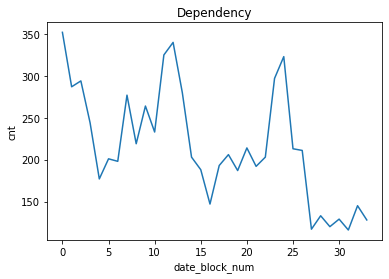

In [27]:
series = neg_item_cnt_day.groupby('date_block_num').date.agg('count').reset_index().rename({'date': 'cnt'}, axis=1)

sns.lineplot(data=series, x='date_block_num', y='cnt').set_title('Dependency')
print(f"Amount of shops with at least 1 potential return: {len(neg_item_cnt_day.groupby('shop_id').date.agg('count').reset_index().rename({'date': 'cnt'}, axis=1))}")

They are returns

### Outlier numerical DCQ

[sales_train | item_cnt_day] Markov thresh on 1.0%: 124.8337284739967
[sales_train | item_cnt_day] Markov thresh on 0.5%: 249.6674569479934
[sales_train | item_cnt_day] Markov thresh on 0.1%: 1248.337284739967
[sales_train | item_price] Markov thresh on 1.0%: 89085.35364784647
[sales_train | item_price] Markov thresh on 0.5%: 178170.70729569293
[sales_train | item_price] Markov thresh on 0.1%: 890853.5364784646


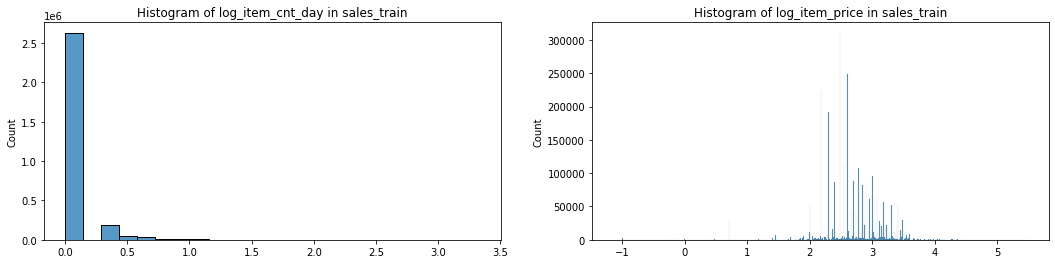

In [28]:
candidates = [
    ('sales_train', 'item_cnt_day'),
    ('sales_train', 'item_price')
] 

fig, axs = plt.subplots(1,len(candidates), figsize=(18, 4))

for idx, (tbl, col) in enumerate(candidates):
    vals = list(filter(lambda x: x > 0, data[tbl][col].to_numpy().flatten()))
    
    is_log = max(vals) - min(vals) > 1e3
    
    sns.histplot(data=np.log10(vals) if is_log else vals, ax=axs[idx]).set_title(f'Histogram of {"log" if is_log else None}_{col} in {tbl}')
    for perc in [0.01, 0.005, 0.001]:
        print(f"[{tbl} | {col}] Markov thresh on {100 * perc}%: {markov_probability_tresh(vals, prob=perc)}")

### Initial filters **dqc**

In [29]:
pd_create__filter_no_neg_price__mask = lambda df: (df.item_price > 0)
pd_create__filter_no_returns__mask = lambda df: (df.item_cnt_day >= 0)

pd_create__filter_outliers__price__mask = lambda df: (df.item_price < 178179)
pd_create__filter_outliers__cnt__mask = lambda df: (df.item_cnt_day < 250)

etl__filter_registry = {
    'sales_train': [
        pd_create__filter_no_neg_price__mask,
        pd_create__filter_no_returns__mask,
        pd_create__filter_outliers__price__mask,
        pd_create__filter_outliers__cnt__mask,
    ]
}

def etl__apply_filters(data):
    def _process_tbl(df, handlers):
        _df = df.copy()
        for handler in handlers:
            _df = _df[handler(_df)]
            
        return _df
    
    imm_data = {
        tbl_name: _process_tbl(
            df=data[tbl_name], 
            handlers=etl__filter_registry[tbl_name] if tbl_name in etl__filter_registry.keys() else []) for tbl_name in data.keys()
    }
    return imm_data

create_acf_report = lambda raw_acf_report: (pd.DataFrame(
    data=np.array([
        [i for i in range(0, len(raw_acf_report))],
        acf(raw_acf_report)
    ]).T,
    columns=['lag', 'acf_value']
)) 

def eda__create_dynamic_report(df, cat_col, ts_col, agg_map):
    cat_col = cat_col if not isinstance(cat_col, str) else [cat_col]
    ts_col = ts_col if not isinstance(ts_col, str) else [ts_col]
    tgt_col = list(agg_map.keys())[0]
    
    imm_df_dynamic = (df
     .groupby([*cat_col, *ts_col])
     .agg(agg_map)
     .reset_index()
     .pivot(index=cat_col, columns=ts_col, values=tgt_col)
     .fillna(0)
     .stack()
     .reset_index()
     .rename({0: tgt_col}, axis=1)
    )
    
    return imm_df_dynamic

def eda__create_categorical_acf_report(df, cat_col, ts_col, agg_map):
    cat_col = cat_col if not isinstance(cat_col, str) else [cat_col]
    ts_col = ts_col if not isinstance(ts_col, str) else [ts_col]
    tgt_col = list(agg_map.keys())[0]
    
    imm_df_dynamic = (df
     .groupby([*cat_col, *ts_col])
     .agg(agg_map)
     .reset_index()
     .pivot(index=cat_col, columns=ts_col, values=tgt_col)
     .fillna(0)
     .stack()
     .reset_index()
     .rename({0: tgt_col}, axis=1)
    )
    
    acf_list = []
    for cat, subframe in imm_df_dynamic.groupby(cat_col):
        acf_vals = acf(subframe[tgt_col].values)
        acf_subframe = (pd.DataFrame(
            data=np.array([
                [i for i in range(0, len(acf_vals))],
                acf_vals
            ]).T,
            columns=['lag', 'acf_value']
        )) 
        acf_subframe[f'{cat_col}'] = cat
        
        acf_list.append(acf_subframe)
        
    acf_report = pd.concat(acf_list, axis=0)
    return acf_report      

def dqc_inspection__dynamic(df):
    df_agg = df.groupby(['date__weeks_since_hstart']).agg({
        'item_price': ['mean', 'sum'],
        'item_id': 'count',
    })
    
    fig, axs = plt.subplots(len(df_agg.columns), 1, figsize=(10, len(df_agg.columns) * 5))
    
    for idx, col in enumerate(df_agg.columns):
        sns.lineplot(x=df_agg.index, y=df_agg.loc[:,col], ax=axs[idx]).set_title(f"{col} - dynamic")

## 1.2 DQC on sell dynamics

### First of all lets create flat table schema

Analytic applications cannot rely on dafault **`OLTP`** schema, as it slightly can be used in terms of multiple joins for each request

In [30]:
imm_data = etl__apply_filters(data)



raw_item__df = imm_data['items']
raw_item_cat__df = imm_data['item_categories']
raw_sales__df = imm_data['sales_train']
raw_shop__df = imm_data['shops']

In [31]:
imm_flat_df = (raw_sales__df
                   .merge(
                       raw_item__df, on='item_id', how='left'
                   )
                   .merge(
                       raw_item_cat__df, on='item_category_id', how='left'
                   )
                   .merge(
                       raw_shop__df, on='shop_id', how='left'
                   )
)
imm_flat_df['date'] = pd.to_datetime(imm_flat_df["date"])
imm_flat_df['date__days_since_hstart'] = (imm_flat_df['date'] - min(imm_flat_df['date'])).dt.days
imm_flat_df['date__weeks_since_hstart'] = imm_flat_df['date__days_since_hstart'] // 7

imm_flat_df['date__day_of_month'] = imm_flat_df['date'].dt.day
imm_flat_df['date__day_of_week'] = imm_flat_df['date'].dt.dayofweek
imm_flat_df['date__week_of_year'] = imm_flat_df['date'].dt.weekofyear
imm_flat_df['date__month_of_year'] = imm_flat_df['date'].dt.month
imm_flat_df['date__year'] = imm_flat_df['date'].dt.year

imm_flat_df.rename({'date_block_num': 'date__month_since_hstart'}, inplace=True, axis=1)

imm_flat_df.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928462 entries, 0 to 2928461
Data columns (total 17 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   date__month_since_hstart  int64         
 2   shop_id                   int64         
 3   item_id                   int64         
 4   item_price                float64       
 5   item_cnt_day              float64       
 6   item_name                 object        
 7   item_category_id          int64         
 8   item_category_name        object        
 9   shop_name                 object        
 10  date__days_since_hstart   int64         
 11  date__weeks_since_hstart  int64         
 12  date__day_of_month        int64         
 13  date__day_of_week         int64         
 14  date__week_of_year        int64         
 15  date__month_of_year       int64         
 16  date__year                int64         
dtypes: datet

As we can see, item_cnt_day has float64 type, it seems to be strange and it should be checked on the EDA stage.

## Dynamic inspection

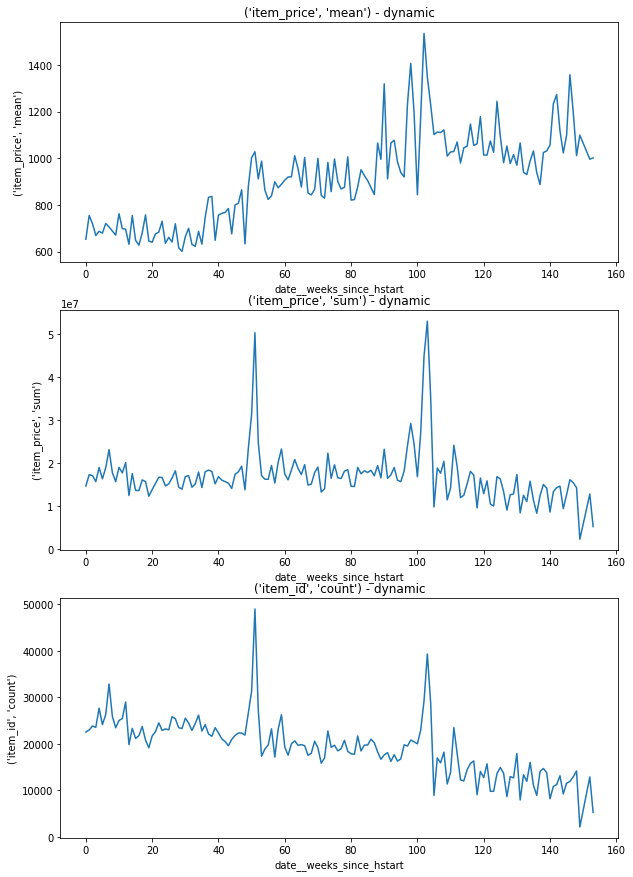

In [32]:
dqc_inspection__dynamic(imm_flat_df)

As we can see, there are some peaks which we should explore, maybe we'll could find some lag correlations or cycles. 